In [1]:
import os
# print(os.getcwd())
# os.chdir('/gladstone/engelhardt/home/hvu/source/RNA_rates/splicingrates/simulations')
import numpy as np
import scipy
import seaborn as sns
from transcription.experiment import Experiment
from transcription import simulate_multiple_experiments as sim
import visualize_simulations as viz
import matplotlib.pyplot as plt
from transcription import from_reads_to_coverage as read2cov
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'
import helper
import pandas as pd 
ONE_KB=1000
SIM_FEAT_LEN = 5000 # length of one feature in the simulation
SEED = 9999
np.random.seed(SEED)

importing simulate_multiple_experiments


In [2]:
target_exp = 5
num_total_transcript_millions = 100
degrade_rate = 0.00
intron_h = 5
PAS_h=5
RTR=500
lambda_init = 2 # average number of burst events per minute (burst event is the event where a burst_size transcripts are created around the same time)
burst_size = 10 # number of transcripts created in a burst event
wiggle_room = 0.3 # the wiggle room for the burst event. See the comments in function Experiment.init_bursting_transcripts to understand the meaning of this parameter. If not sure, don't modify it.
# if I want to simulate situation such that there is no read being generated from fragments (only the whole transcripts are sequenced), the following parameters should be set carefully:
eta_val=helper.DFT_ETA_VALUE  # the scale fo weibull distribution for the fragment length
insertsize_min = 200 #200  #filter fragments minimum length
insertsize_max = 300 #300  # filter fragments maximum length
read_length = 100 #150 # the length of the reads
frag_func= 'weibull_edge' # whether we will simulate the fragmentation of transcripts based on the weibull distribution or the uniform fragmentation method
unif_avg_frag_len=250 # the desired average fragment length if we use the uniform fragmentation method
# if I set the read values to -1, the program will just generate fragments and not get rid of any portion of the fragments.
simulate_cleavage=False ## for this problem, we don't need to simulate cleavage because we really only care about calculating the elongation speed of the transcripts. We skip splicing and cleavage for now.
PDB = False  # whether we simulate a system where there is no existing transcripts, and instead we used PDB to stop the transcripts from elongation, and let the elongation to start PDB_time minutes before we introduce the first tag
label_time = np.arange(4) if PDB else np.arange(3)
time_interval=5
label_time = time_interval*label_time
num_timepoints = len(label_time)
max_time_for_equilibrium = 50
save_folder = None # './exon2_4Fold/'
pair_end=False


In [3]:
gtf_df = sim.create_variable_gtf_df(nExons=2, length_fold_list=[1.65, 1.65, 1.65],
                                    elong_fold_list=None, intronH_fold_list=[5] * 3,
                                    SIM_FEAT_LEN=ONE_KB)
# gtf_df says all the features of the gene. recommend: look at this df on terminal
elongf_df = sim.create_elongf_df(elong_fold_list=[0.33, 0.33, 0.33, 0.33, 0.33], length_fold_list=[1.65,0,1.65,0,1.65], SIM_FEAT_LEN=ONE_KB)
gtf_df, elongf_df = sim.align_gtf_df_with_elongf_df(gtf_df, elongf_df)
exp_list = sim.generate_exp_given_one_gtf(gtf_df, elongf_df = elongf_df, save_folder=save_folder, label_time=label_time,
                                          target_exp=target_exp,
                                          num_total_transcript_millions=num_total_transcript_millions,
                                          lambda_init=lambda_init, burst_size=burst_size,
                                          wiggle_room=wiggle_room, eta_val=eta_val,
                                          insertsize_min=insertsize_min, insertsize_max=insertsize_max,
                                          read_length=read_length, simulate_cleavage=simulate_cleavage, PDB=PDB,
                                          max_time_for_equilibrium=max_time_for_equilibrium, pair_end=pair_end,
                                          frag_func=frag_func)
# exp_list is a list of 3, correpsoding to 3 timepoints. Each element is an Experiment object, which contains the list of transcripts 
endpoint_df = read2cov.get_endpoints_across_time(exp_list)
# coverage_df = read2cov.count_timeDep_read_coverage(exp_list[-1], endpoint_df, N=1, num_timepoints=len(exp_list))



last_txrate: 0.33
inside generate_exp_given_one_gtf
before adding new experiments
474
574
654


In [5]:
# print the gtf_df and elongf_df
print(gtf_df)
print(elongf_df)

    feature  start   end  length  is_intron  intron_h  is_PAS  PAS_h
0    exon_1      0  1650    1650      False       0.0   False    0.0
1  intron_1   1650  3300    1650       True       5.0   False    0.0
2    exon_2   3300  4950    1650      False       0.0   False    0.0
3       PAS   4950  4951       1      False       0.0    True    1.0
4       RTR   4951  9951    5000      False       0.0   False    0.0
   length  txrate   start     end
0  1650.0    0.33     0.0  1650.0
1     0.0    0.33  1650.0  1650.0
2  1650.0    0.33  1650.0  3300.0
3     0.0    0.33  3300.0  3300.0
4  1650.0    0.33  3300.0  4950.0
5     inf    0.33  4950.0     inf


# How accurate is my algorithm to calculate the elongation speed of the transcripts?
Create simulation of genes with no introns, and cleavage is not simulated. Only initiation and elongation of transcripts are simulated. Functions to write:
- Things that I need to vary about a gene that I am trying to simulate: In Pat et al., 2017 to measure intron splicing rate, this is what we have: intron length i (40nt – 100 kb), downstream distance d (1–5 kb), expression level in TPM (1–46 TPM), labeling periods L (5, 10, 20, and 60 min) and half-lives h (0.2–100 min). 
- Things that I need to vary: (1) experiment with intiation parameters varied, (2) experiment with initiation parameters keptconstant. In both experiments, the following should be varied: (1) gene length (length of features along the gene), (2) number of features (exons) with varible length and elongation rates.
- I dont need to repeat each experiment multiple times. 
- (1) experiment where there is a constant number of features, and feature length. The elongation rate of the features are varied.
- (2) experiment where there is a constant number of features, varied feature length and elongation rate.
- (3) experiment where there is a varied # features, varied feature length and elongation rate. 
- In all experiments, ignore the predictions of the PAS. Ignore the predictions that are np.inf, because those correspond to regions of the genome that the transcripts have not reached yet and hence no data is observed. 

## Experiment 1.1: Vary the elongation rate of the features, but # features and feature length are constant. Initalization parameters are constant.
- A standard function to create standard gtf_df with constant # features and feature length. --> done
- A standard function to create new gtf_df from the standard gtf_df, but with varied elongation rate of the features.
- A function to simulate the experiment with the new gtf_df, and calculate the elongation rate of the transcripts. 
- A function to compare the estimated elongation rates with the true elongation rates. 
- A function to repeat this experiment multiple times, and report into .csv and plots about the accuracy of the estimation.
 

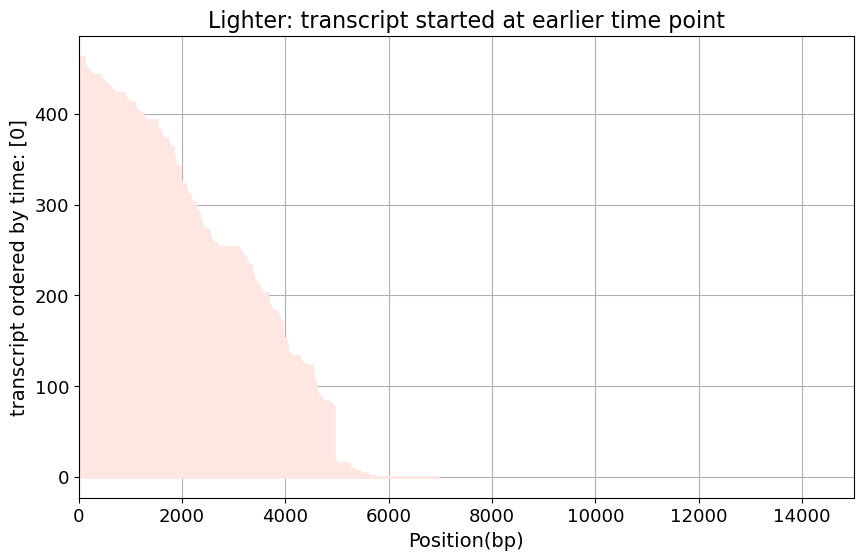

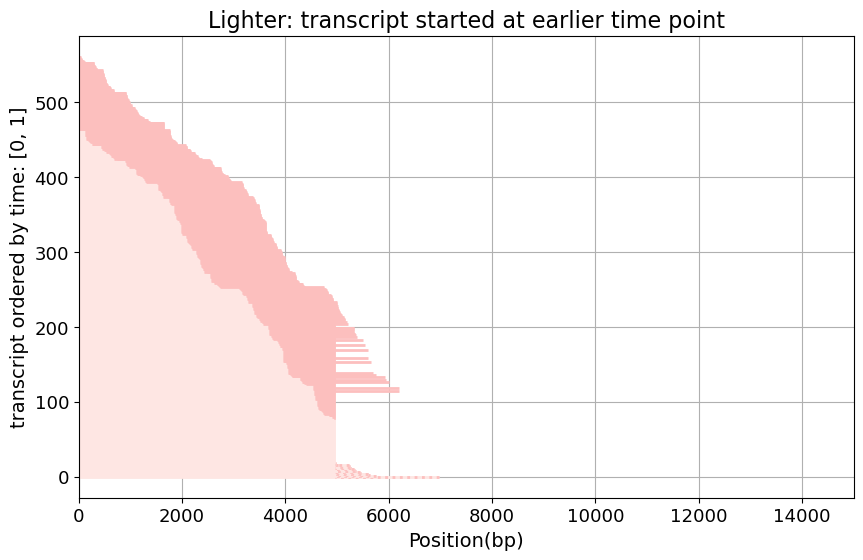

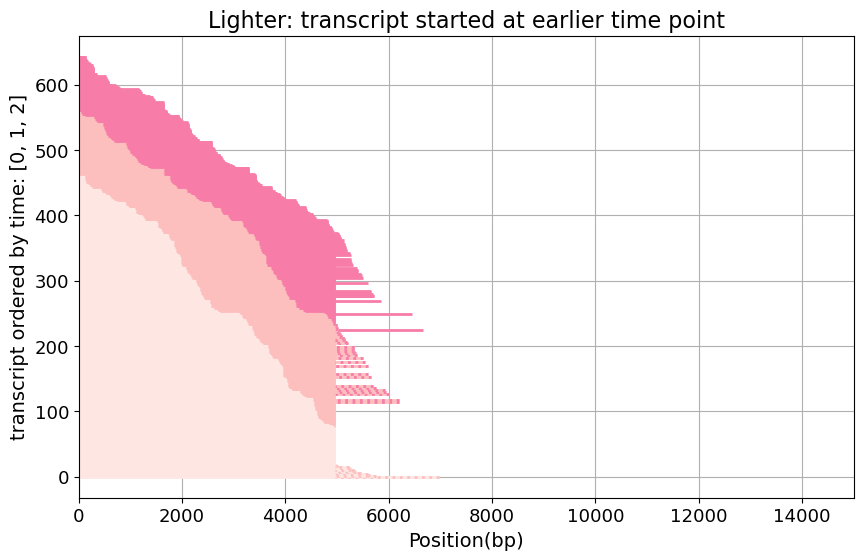

In [5]:
for i in range(len(exp_list)):
    # coverage_df = viz.plot_timeTagged_read_coverage(exp_list[:(i+1)], smooth_N=1, gap_N=200, xaxis_N=50, width=1, stacked=False, ylim=(0,300), time_to_plot=range(i,i+1)
    viz.plot_all_times_endsite(exp_list[:(i+1)], lower_idx=0, upper_idx=720, line_width=2, y_order_by_time=False, xlim=(0,15000))

In [4]:
import importlib
importlib.reload(viz)
coverage_df = viz.plot_timeTagged_read_coverage(exp_list, smooth_N=1, gap_N=1, xaxis_N=10, width=1, stacked=True, ylim=(0,650), xlim=(0,3000), time_to_plot=[0,1,2])

TypeError: count_timeDep_read_coverage() got an unexpected keyword argument 'N'

xlim: (0, 7000)
        0    1    2
9946  0.0  0.0  0.0
9947  0.0  0.0  0.0
9948  0.0  0.0  0.0
9949  0.0  0.0  0.0
9950  0.0  0.0  0.0


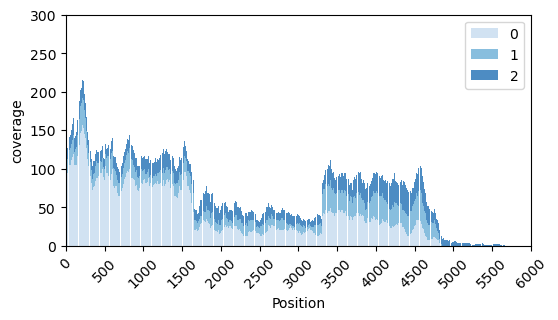

In [5]:
endpoint_df = read2cov.get_endpoints_across_time(exp_list) # there can be transcripts where all the endpoints are 0 across timepoints. That is because of how the init_new_transcript function works: the last batch of transcripts creaited are time_since_prev=0, so they don't elongate. 
coverage_df = read2cov.count_timeDep_read_coverage(exp_list[-1], endpoint_df, num_timepoints=len(exp_list))
edgeCorrected_cov_df = read2cov.correct_first_fragment_effects(exp_list[-1], coverage_df)
plot_df = edgeCorrected_cov_df[[0,1,2]] # we do not need to plot every datapoints
viz._plot_barplot_for_coverage(plot_df, xaxis_N=100, title=None, xlabel='Position', ylabel='coverage', figsize=(6,3), cmap_color= 'Blues', stacked=True, width=0.9, ax=None, grid=False, ylim=(0,300), xlim=(0,7000), save_fn='trial.png')

xlim: (0, 5000)
        0    1    2
9946  0.0  0.0  0.0
9947  0.0  0.0  0.0
9948  0.0  0.0  0.0
9949  0.0  0.0  0.0
9950  0.0  0.0  0.0


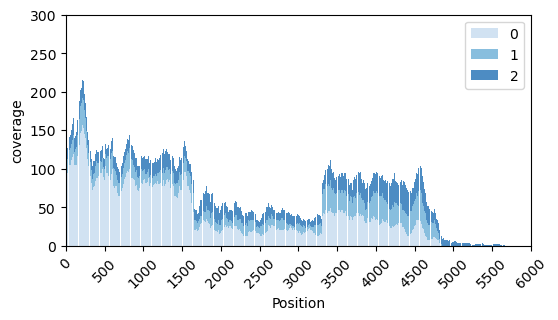

In [15]:
plot_df = edgeCorrected_cov_df[[0,1,2]] # we do not need to plot every datapoints
import importlib
importlib.reload(viz)
viz._plot_barplot_for_coverage(plot_df, xaxis_N=100, title=None, xlabel='Position', ylabel='coverage', figsize=(6,3), cmap_color= 'Blues', stacked=True, width=0.9, ax=None, grid=False, ylim=(0,300), xlim=(0,5000))

In [22]:
# NOte: with PBD, startT_idx has to ve 1. Otherwise the pipeline will fail.
startT_idx = 0
endT_idx=1
nExons=2
from estimates.elongation import estElong
import importlib
importlib.reload(estElong)
# px0, py0, px1, py1, x0, x1 = estimate_endpoints_acrossTime(coverage_df, startT_idx=startT_idx, endT_idx=endT_idx, time=5, max_segments=30)
h, h_mean = estElong.calculate_h_from_coverage(coverage_df, gtf_df, startT_idx=startT_idx, endT_idx=endT_idx, time=5, max_segments=15, trim_N=0, trim_endGene=False , subsample_frac=1, SEED=9999, nIter=1, convert_to_KB=True, gapN=1)
gtf_df.reset_index(drop=True, inplace=True)
print(h_mean)
print(gtf_df.loc[:, 'txrate'])

We will conver the genomic positions in terms of kilo-bases
Output will be in KB/min
Start calculating elongation rate
endpoints: [0.    1.65  3.3   4.95  4.951   inf]
fixed. py[i] - curr_y:  46.367600801004755
py[i]:  342.6882801216841
curr_y:  296.32067932067935
fixed. py[i] - curr_y:  17.86140502956846
py[i]:  294.2592813568639
curr_y:  276.3978763272954
fixed. py[i] - curr_y:  3.772769003438782
py[i]:  231.8215892053973
curr_y:  228.0488202019585
fixed. py[i] - curr_y:  2.4871101151452706
py[i]:  220.95737498271149
curr_y:  218.47026486756621
fixed. py[i] - curr_y:  27.491610554330606
py[i]:  231.4036545323416
curr_y:  203.91204397801098
fixed. py[i] - curr_y:  8.473670032661829
py[i]:  163.94552723638182
curr_y:  155.47185720372
fixed. py[i] - curr_y:  22.24987707643966
py[i]:  124.99050474762619
curr_y:  102.74062767118653
fixed. py[i] - curr_y:  11.448372328813463
py[i]:  114.189
curr_y:  102.74062767118653
fixed. py[i] - curr_y:  1.9840100099728915
py[i]:  104.72463768115942
cu

In [12]:
gtf_df

,feature,start,end,length,txrate,is_intron,intron_h,is_PAS,PAS_h,time
0,exon_1,0.0,1650.0,1650.0,0.33,False,NaN,False,0.0,5.000
1,intron_1,1650.0,3300.0,1650.0,0.33,True,inf,False,0.0,5.000
2,exon_2,3300.0,4950.0,1650.0,0.33,False,NaN,False,0.0,5.000
3,PAS,4950.0,4951.0,1.0,1.00,False,0.0,True,1.0,0.001
4,RTR,4951.0,6601.0,1650.0,0.33,False,0.0,False,0.0,5.000


If startT_idx!= endT_idx-1 thenthe plot may be very wrong. I do not fix it yet
fixed. py[i] - curr_y:  0.3110000934919981
py[i]:  290.0
curr_y:  289.688999906508
fixed. py[i] - curr_y:  0.1846621310423302
py[i]:  90.18466213104233
curr_y:  90.0
fixed. py[i] - curr_y:  1.0814409322524199
py[i]:  19.08144093225242
curr_y:  18.0
coverage_df
       0    1    2  position
0.0  335  148  141         0
1.0  335  148  140         1
2.0  335  148  140         2
3.0  335  148  140         3
4.0  335  148  139         4
tdf
       0    1  position
0.0  335  483         0
1.0  335  483         1
2.0  335  483         2
3.0  335  483         3
4.0  335  483         4
fixed. py[i] - curr_y:  0.3110000934919981
py[i]:  290.0
curr_y:  289.688999906508
fixed. py[i] - curr_y:  0.1846621310423302
py[i]:  90.18466213104233
curr_y:  90.0
fixed. py[i] - curr_y:  1.0814409322524199
py[i]:  19.08144093225242
curr_y:  18.0
fixed. py[i] - curr_y:  0.02723077833360321
py[i]:  250.0
curr_y:  249.9727692216664


/tmp/ipykernel_2088365/3085257579.py:40: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-og" (-> color='g'). The keyword argument will take precedence.
  ax.plot(px0, py0, '-og', color='green')  # green


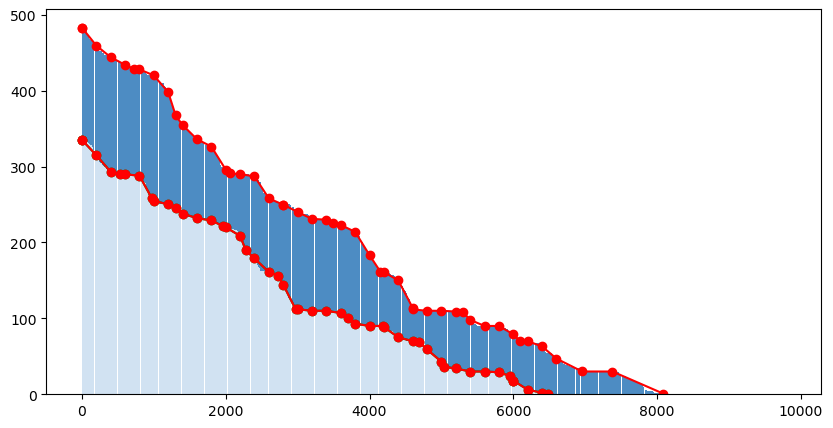

In [16]:
import importlib
importlib.reload(estElong)
endpoint_df = read2cov.get_endpoints_across_time(exp_list) # there can be transcripts where all the endpoints are 0 across timepoints. That is because of how the init_new_transcript function works: the last batch of transcripts creaited are time_since_prev=0, so they don't elongate. 
coverage_df = read2cov.count_timeDep_read_coverage(exp_list[-1], endpoint_df, N=1, num_timepoints=len(exp_list))
def plot_piecewise_regression_multiple_timepoints(coverage_df, startT_idx:int, endT_idx:int, max_segments=15, xlim=None):
    print('If startT_idx!= endT_idx-1 thenthe plot may be very wrong. I do not fix it yet')
    # coverage_df = (coverage_df.loc[:3000, :]).copy()
    convert_to_KB = False
    coverage_df = estElong.convert_gene_to_KB(coverage_df, convert_to_KB=convert_to_KB)
    coverage_df = estElong.clean_edgeEffect_region_from_coverage(coverage_df, trim_N=0)
    gene_length = gtf_df['end'].max()
    endpoints = np.arange(0, gene_length, 200)
    # px0, py0, px1, py1, x0_, x1_, _ = estElong.estimate_endpoints_acrossTime(coverage_df, startT_idx, endT_idx, max_segments, gapN=10)
    import regression.piecewise_linear_regression as pwlr
    px0, py0 = estElong.piecewise_linearRegression_no_trailing_zeroes(coverage_df['position'].values, coverage_df[startT_idx].values, endpoints= endpoints, max_segments = max_segments)
    print('coverage_df')
    print(coverage_df.head())
    tdf = estElong.calculate_culmulative_coverage(coverage_df, startT_idx, endT_idx, gapN=1)
    print('tdf')
    print(tdf.head())
    # first fit two piece-wise linear regressions to the coverage data for both timepoints
    # here, x is the genomic position, and y is the coverage at time t
    px0_w, py0_w = estElong.piecewise_linearRegression_no_trailing_zeroes(tdf['position'].values, tdf[startT_idx].values, endpoints=endpoints, max_segments=max_segments)
    px1, py1 = estElong.piecewise_linearRegression_no_trailing_zeroes(tdf['position'].values, tdf[endT_idx].values, endpoints=endpoints, max_segments=max_segments)
    plot_df = coverage_df.loc[::10] # we do not need to plot every datapoints
    cmap = sns.color_palette('Blues', n_colors=3)
    colors = [cmap[i] for i in range(3)]
    fig, ax = plt.subplots(figsize=(10,5))
    width = 9.5
    ax.bar(plot_df['position'], plot_df[startT_idx], color=colors[0], alpha=0.8, label=startT_idx, width=width)
    ax.bar(plot_df['position'], plot_df[endT_idx], color=colors[2], bottom=plot_df[startT_idx], alpha=0.8, label=endT_idx, width=width)
    #plot the area between the two regression line
    # x_common = np.union1d(px0, px1)
    # # Interpolate y values for this common x array
    # py0_interp = np.interp(x_common, px0, py0)
    # py1_interp = np.interp(x_common, px1, py1)
    # ax.plot(x_common, py0_interp, label='Line 1')
    # ax.plot(x_common, py1_interp, label='Line 2')
    # ax.fill_between(x_common, py0_interp, py1_interp, color='skyblue', alpha=0.2)
    ax.plot(px0, py0, '-og', color='green')  # green
    ax.plot(px0_w, py0_w, '-or')  # red
    ax.plot(px1, py1, '-or')  # red
    # ax.plot(x0, y0, '-or', color='green', alpha=0.1)
    # ax.plot(x1, y0, '-or', color='green', alpha=0.1)
    if xlim is not None:
        ax.set_xlim(xlim)
    return px0, py0, px1, py1


px0, py0, px1, py1 = plot_piecewise_regression_multiple_timepoints(coverage_df, startT_idx=0, endT_idx=1, max_segments=15, xlim=None)
# print(px0, py0)
# print(px1, py1)

In [11]:
coverage_df

,0,1,2,position
0,380,93,112,0.000
1,380,93,112,0.001
2,380,93,112,0.002
3,380,93,112,0.003
4,380,93,112,0.004
...,...,...,...,...
27882,0,0,1,27.882
27883,0,0,1,27.883
27884,0,0,1,27.884
27885,0,0,1,27.885


In [8]:
print(px0, py0)
print(px1, py1)

[    0.          5039.99999996 10416.00528603 16908.82552148
 24945.        ] [ 1.11793061e+02  8.95458206e+01  7.77722376e+01  2.68016169e+00
 -8.50337436e-04]
[    0.         14001.72353652 24945.        ] [141.40350397  82.79319133 -14.53601944]


In [14]:
tx0 = np.array([0, 2000,  3500, 5500, 10500])
ty0 = estElong.x_to_y_array(tx0, px0, py0)
tx1 = estElong.y_to_x_array(ty0, px1, py1)
print(tx0)
print(tx1)
time =5
endpoints = estElong.get_endpoints_from_gtf(gtf_df)
n = len(x0) # number of datapoints that we have to estimate elongation rate
m = len(endpoints) # the last feature is the last segment that do not correspond to any feature in the gene, but we keep them here for the sake of simulation
# based on x0,x1 and endpoints, find the coefficient matrix A (size n*m)
A = estElong.findA(x0, x1, endpoints)
b = np.ones(n) * time
# Computing the least squares solution
from scipy.optimize import lsq_linear
res = lsq_linear(A, b, bounds=(0, np.inf))  # A*h_inv = b, with A(n,m), h_inv(m,), b(n,)
h = 1 / res.x
print(A)
print(h)
print(gtf_df['txrate'])

[    0  2000  3500  5500 10500]
[ 8852.22413197  9398.21047603 10081.01134153 10394.82777575
 13174.72572283]
[[3500.         2000.         3352.22413197 ...    0.
     0.            0.        ]
 [3499.         2000.         3352.49712514 ...    0.
     0.            0.        ]
 [3498.         2000.         3352.77011831 ...    0.
     0.            0.        ]
 ...
 [   0.            0.         2267.         ... 2515.90351238
     0.            0.        ]
 [   0.            0.         2266.         ... 2516.87879582
     0.            0.        ]
 [   0.            0.         2265.         ... 2517.85407925
     0.            0.        ]]
[2848.8013218  4393.79147341  986.48634148   11.49795616  962.11994409
           inf           inf]
0    3.6
2    3.6
4    1.0
5    1.0
6    1.0
Name: txrate, dtype: float64


/tmp/ipykernel_3626875/2977560104.py:16: RuntimeWarning: divide by zero encountered in divide
  h = 1 / res.x


In [13]:
coverage_df.to_csv('from_notebook.csv.gz', header=True, index=False, compression='gzip')

In [27]:
px0, py0, px1, py1, x0, x1 = estimate_endpoints_acrossTime(coverage_df, startT_idx, endT_idx, time=5, max_segments=15)
endpoints = gtf_df[['start', 'end']].values
endpoints = np.concatenate((endpoints[:, 0], [endpoints[-1, 1]]))
trim_N = 500
trim_N = estElong.find_optimal_trimN(x0,x1,trim_N)
x0 = x0[trim_N:-trim_N]
x1 = x1[trim_N:-trim_N]
n=len(x0) # number of datapoints that we have to estimate elongation rate
m=len(endpoints) # number of features for which we will calculate the elongation rate (all features in gtf_df and one last feature that do not correspond to the any feature in the gene, but we keep them here for the sake of simulation)
# based on x0,x1 and endpoints, find the coefficient matrix A (size n*m)
A = estElong.findA(x0, x1, endpoints)
time=5
b = np.ones(n) * time
# Computing the least squares solution
print('Done setting up the least-square problem')
from scipy.optimize import lsq_linear
res = lsq_linear(A, b, bounds=(0, np.inf))  # A*h_inv = b, with A(n,m), h_inv(m,), b(n,)
h = 1/res.x

fixed. py[i] - curr_y:  36.05925185617443
py[i]:  115.72396311030485
curr_y:  79.66471125413042
fixed. py[i] - curr_y:  17.814681161744147
py[i]:  97.47939241587457
curr_y:  79.66471125413042
fixed. py[i] - curr_y:  53.65022948084638
py[i]:  133.3149407349768
curr_y:  79.66471125413042
fixed. py[i] - curr_y:  61.78387061969366
py[i]:  141.44858187382408
curr_y:  79.66471125413042
fixed. py[i] - curr_y:  58.046090859435736
py[i]:  137.71080211356616
curr_y:  79.66471125413042
fixed. py[i] - curr_y:  79.1051452025794
py[i]:  158.76985645670982
curr_y:  79.66471125413042
fixed. py[i] - curr_y:  35.92577934451208
py[i]:  115.5904905986425
curr_y:  79.66471125413042
fixed. py[i] - curr_y:  13.677344638597503
py[i]:  93.25593161826927
curr_y:  79.57858697967177
fixed. py[i] - curr_y:  0.0024558828163484562
py[i]:  0.0007598520939672824
curr_y:  -0.0016960307223811738
fixed. px[i] - curr_x:  -55.21849976084377
px[i]:  13213.026172673019
curr_x:  13268.244672433862
fixed. py[i] - curr_y:  57.9

In [28]:
print(h)

[4.36613890e+20 1.25084357e+22 4.57916731e+24 1.68617331e+26
 9.50984719e+02 1.00000000e+01]


In [ ]:
# plot h against the genomic position
plot_df = pd.DataFrame({'x':x0, 'h':h})
last_non_zero_index = coverage_df[0][coverage_df[0] != 0].last_valid_index()
if last_non_zero_index is not None:  # else do nothing
    plot_df = plot_df.loc[:last_non_zero_index]
plot_df = plot_df[::100]
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(plot_df['x'], plot_df['h'], '.', color='red')
plt.grid()
# now, only consider the start and end point of each segment in gtf_df and calculate the elongation speed
plt.ylim((0,2400))

In [18]:
coverage_df.tail()

,0,1,2,position
19777,1,79,76,19777
19778,1,79,76,19778
19779,1,79,76,19779
19780,1,79,76,19780
19781,1,79,76,19781


Here, we are trying to solve a very simple problem: Assume I start with almost uniformly distributed cars on the roads (cars are quite evenly spaced out on the road), and also assume that cars all travel at the same speed along the length of the road. At t=0, I have data of how many cars have passed through each sensor in the past infinite time (i.e since there is no car on the road whatsoever). At t=1, I have data of how many cars have passed each sensor since t=0 to t=1. At t=2, I have data of how many cars have passed each sensor since t=1 to t=2. The question is: can I infer the initial distribution of cars on the road at t=0? And then, can I infer the speed of the cars?
This problem is a very simplified version of what could happen in the context of mRNA transcription. Here are the assumptions that simplfied the problem:
- No introns
- No new transcripts are created after t=0
- No degradation of transcripts
- No splicing
- No alternative polyadenylation
- No alternative transcription start site
- No alternative transcription end site
- Uniform transcription rate along the length of the transcript
To solve this problem, I used a principle that is fundamental in the field of traffic flow engineer: flow (veh/hr) = density (veh/km) * speed (km/hr). In the context of mRNA transcription, flow = transcription rate (transcripts/hr), density = number of transcripts per unit length (transcripts/kb), speed = transcription rate per unit length (kb/hr). 

The steps to solving this very simple scenario are:
- Step 1: Infer the transcripts endpoint based on read coverage at t=0
- Step 2: Find the genomic position (position on the road) where there is a peak in the flow from t=0 to t=1
- Step 3: Calculate the density of cars (transcript end points) from gene_start (road start) to the peak position
- Step 4: Apply the formula flow = density * speed to calculate the speed of the cars (transcripts) from gene_start to the peak position

In [ ]:
def calculate_speed_from_timeTagged_coverage(coverage_df, time_idx):
    # find the FIRST position (index) with highest flow from t=0 to t=1
    maxFlow_idx = coverage_df[time_idx].idxmax() # the first row with highest value in column 1 (first position with highest flow)
    # calculate the coverage from previous timepoint, which is equal to the sum of time-tagged coverage from time point 0 to the timepoint BEFORE the time_idx
    coverage_df['prev'] = coverage_df.iloc[:, :time_idx].sum(axis=1)
    # now, calculate the density of cars (transcripts) from gene_start to the peak position at t=0
    # this can be estimated by the difference in coverage from position 0 to the peak position
    density = (coverage_df.loc[0, 'prev']-coverage_df.loc[maxFlow_idx, 'prev'])/(maxFlow_idx-Experiment.gene_start)
    
    # speed = flow / density, where flow: number of transcripts passing through the peak position from t=0 to t=1 (transcripts/5 minutes) and density: number of transcripts per unit length from gene_start to the peak position (transcripts/bp) --> speed (bp/5 minutes)
    speed = coverage_df.loc[maxFlow_idx,time_idx]/density
    return speed

In [ ]:
# now, if I calculate based on this fomula for positions from gene_start to the peak position, I should get the same values for speed? --> NO. The calculated speed is increasing as we move along the genome. But why? Because our fomula is speed = flow/density. Regardless of the position that we are trying to use to calculate the speed, the density is roughly the same (because we randomly sample the position of cars/ transcript endpoints uniformly along the gene). Therefore, as the flow is a bell curve shape along the gene, the speed will be following a bowl shape along the gene. This formular should only be regarded as an approximation at the FIRST peak position.
trial_df = (coverage_df.loc[:10000, :]).copy()
trial_df['density'] = (trial_df.iloc[0,0]-trial_df[0])/(trial_df.index-Experiment.gene_start)
trial_df['speed'] = trial_df[1]/trial_df['density']

In [ ]:
# If we apply the same approach with reads that are tagged as t=1 to t=2, we should expect the same speed
speed_1 = calculate_speed_from_timeTagged_coverage(coverage_df, 1)
speed_2 = calculate_speed_from_timeTagged_coverage(coverage_df, 2)
print(speed_1, speed_2)

In [ ]:
# bar plot with x-axis: position along the gene, y-axis: speed
fig, ax = plt.subplots(figsize=(10,5))
ax.bar(trial_df.index, trial_df['speed'], width=1)

In [ ]:
trial_df.iloc[20:50,:]

# The stacked prallelle problem 
In this section, I reimagine the problem of finding the speed given that speed is uniform across the gene. We can divide the problem to these following subproblems:
- If we order transcripts by increasing end point. Then, after t minutes, assuming constant speed of mRNA elongation, then the elongated transcripts that can be captured by kinetic barcoding will look like stacked parralelograms. The height of the parralelogram is the number of transcripts that have been elongated by t minutes. The width of the parralelogram is the length of the elongated region in t minutes. 
- The captured read coverage tagged within the t minutes of elongation will be a graph that looks like we make cuts through the stacked parralelograms and report the height that overlap with the cut.
If we want to solve this problem, we will assume that the endpoints of the transcripts by the transcript index plot can be regressed by piece-wise linear function. We find the endpoints of those piece-wise linear functions, and treat them like two of the corners in a parallelogram, and the other two corners can be determined by the width of the parallelogram $w$. We want to find $w$, which is equal to speed of elongation (bp/minutes) * t (minutes).

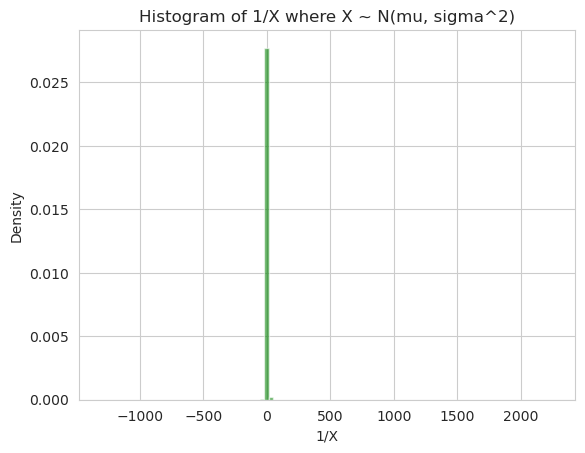

In [2]:
import torch
import matplotlib.pyplot as plt

# Parameters for normal distribution
mu = 1.0  # Mean
sigma = 0.5  # Standard deviation

# Generate samples from normal distribution
x = torch.normal(mu, sigma, size=(10000,))

# Compute reciprocal
y = 1 / x

# Plot histogram of y
plt.hist(y.numpy(), bins=100, density=True, alpha=0.6, color='g')
plt.title('Histogram of 1/X where X ~ N(mu, sigma^2)')
plt.xlabel('1/X')
plt.ylabel('Density')


plt.show()
